In [1]:
# set up enviroment
from __future__ import division
import sys
import numpy as np
import pandas as pd 
import scipy
import importlib
import scanpy as sc

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.manifold import TSNE
import sklearn

pd.options.mode.chained_assignment = None  # default='warn'
from harmony import harmonize

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(figsize=(6,7),dpi_save=600)

scanpy==1.4.6 anndata==0.7.1 umap==0.3.10 numpy==1.17.2 scipy==1.3.1 pandas==0.25.2 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [3]:
adata_all = sc.read_h5ad('../data/adata_all_panPN_annotated_final.h5ad')
adata_all

AnnData object with n_obs × n_vars = 3633 × 17474 
    obs: 'batch', 'genotype', 'stage', 'n_counts', 'n_genes', 'PN_type', 'MARS', 'HDBSCAN', 'MARS_2way_matched', 'MARS_2way_matched_PN_type', 'lineage', '24h_HDBSCAN', 'matched_type_with_stage', 'mannually_matched'
    var: 'highly_variable'
    uns: '24h_HDBSCAN_colors', 'HDBSCAN_colors', 'MARS_2way_matched_PN_type_colors', 'MARS_2way_matched_colors', 'MARS_colors', 'PN_type_colors', 'mannually_matched_colors', 'stage_colors'
    obsm: 'X_tsne'

In [27]:
adata_all.uns['stage_colors']

array(['#47de65', '#ff7f00', '#319ebd', '#2A3CA1'], dtype=object)

In [4]:
adata_all.obs.MARS_2way_matched_PN_type.cat.categories

Index(['APL', 'D', 'DA1_fru+', 'DA1_fru-', 'DA4l', 'DC2', 'DC3', 'DL1', 'DL3',
       'DM2', 'DM6', 'MARS_19', 'MARS_2', 'MARS_25', 'MARS_27', 'MARS_7',
       'MARS_9', 'VA1d', 'VA1v', 'VA2', 'VA5', 'VA6', 'VC2', 'VM2',
       'VM7 or VM5v #1', 'VM7 or VM5v #2', 'nan', 'vPN'],
      dtype='object')

In [5]:
adata_all.obs['matched_type_with_stage'] = adata_all.obs.PN_type.str.cat(adata_all.obs.stage, sep=": ")

In [6]:
np.in1d(adata_all.obs['PN_type'], ['DC3','VA1d','DA1_fru+','DA1_fru-','DL3']).sum()

652

In [8]:
adata_all.obs['mannually_matched'] = adata_all.obs['PN_type']
# get rid of ones not matched mannually
not_matched_0h = ['DC3','VA1d','DA1_fru+','DA1_fru-','DL3','DM2','DC2']
adata_all.obs['mannually_matched'][(np.in1d(adata_all.obs['stage'], ['0h']) 
                                    & np.in1d(adata_all.obs['PN_type'], not_matched_0h))] = 'nan'

In [20]:
# use color dictionary to assigne PNs of the same type in same color
key = ['APL', 'D', 'DA1', 'DA1_fru+', 'DA1_fru-', 'DA3', 'DA4l', 'DC2','DC3','DC3 and VA1d', 'DL1', 
       'DL3', 'DM2', 'VM7 or VM5v #1','VM7 or VM5v #2','DM6', 'VA1d', 'VA1v', 'VA2', 'VA5', 'VA6',
       'VC2', 'VM2', 'vPN','MARS_2', 'MARS_5','nan', 
       'MARS_7', 'MARS_9', 'MARS_19', 'MARS_25', 'MARS_27']
color = ['#023fa5', '#7d87b9', '#cc9da6', '#d6bcc0', '#bb7784', '#8e063b', '#4a6fe3', '#8595e1', '#b5bbe3', '#f060e6',
         '#e07b91', '#d33f6a', '#11c638', '#8dd593', '#c6dec7', '#ead3c6', '#f0b98d', '#ef9708', '#0fcfc0', '#9cded6', '#b33529',
         '#d5eae7', '#f3e1eb', '#f6c4e1', '#f79cd4', '#7f7f7f', '#c7c7c7',
         '#1CE6FF', '#FF4A46', '#008941', '#63FFAC', '#00C2A0']
color_dict = {key[i]:color[i] for i in range(len(key))}

In [21]:
type_order = adata_all.obs['mannually_matched'].cat.categories
adata_all.uns['mannually_matched_colors'] = [color_dict[type] for type in type_order]

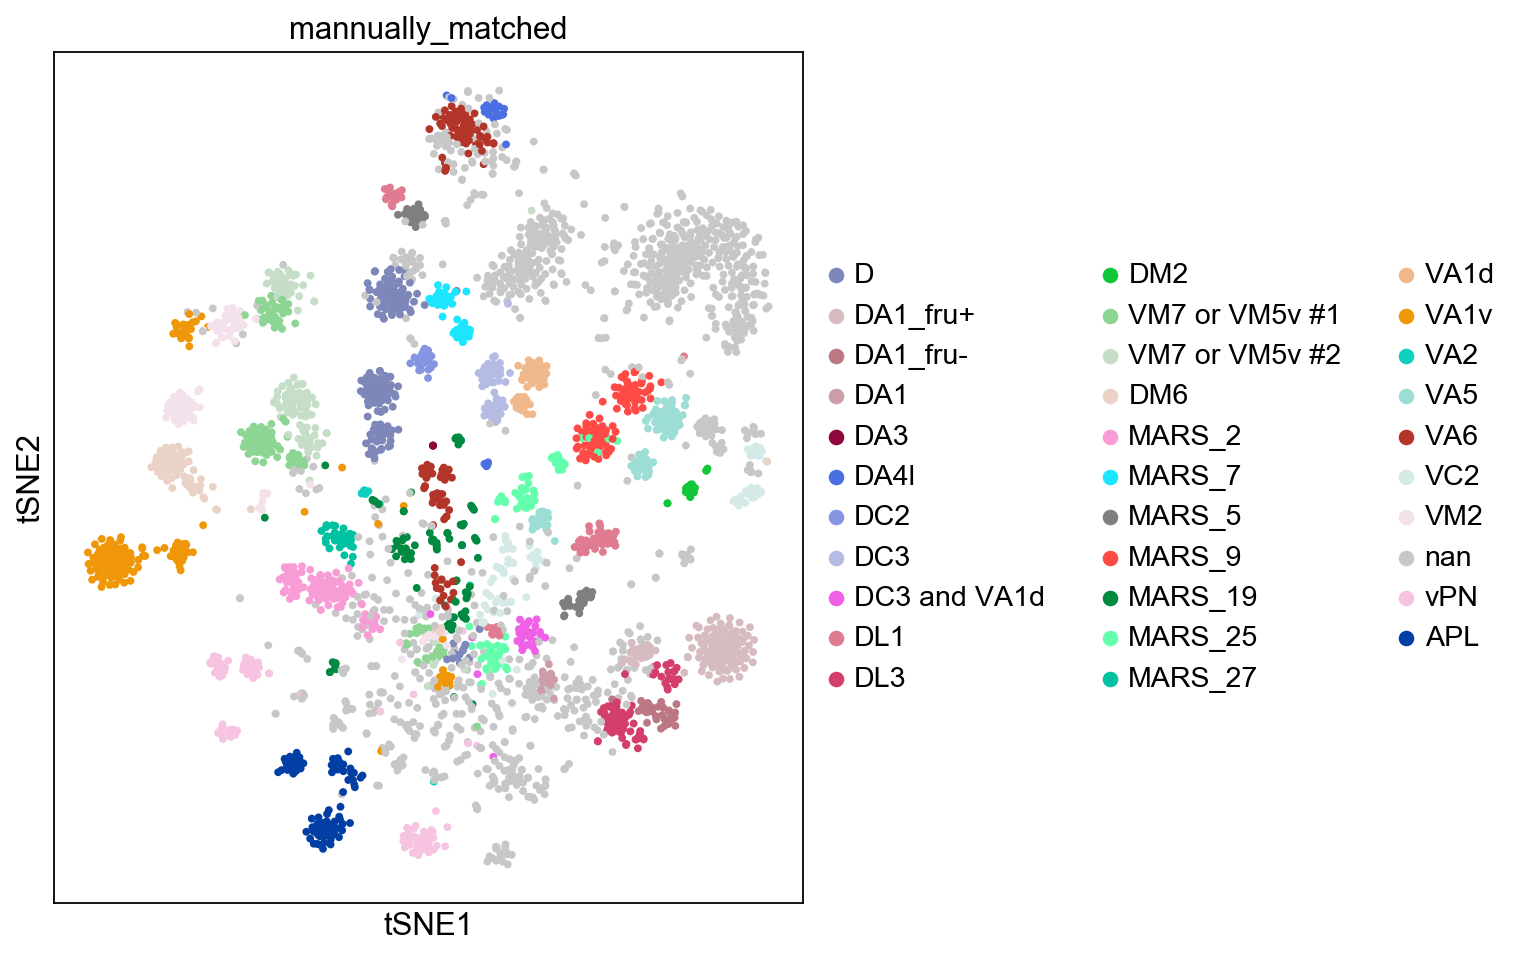

In [22]:
sc.pl.tsne(adata_all,color='mannually_matched', size=(50,50),save='_manual_matched.pdf')

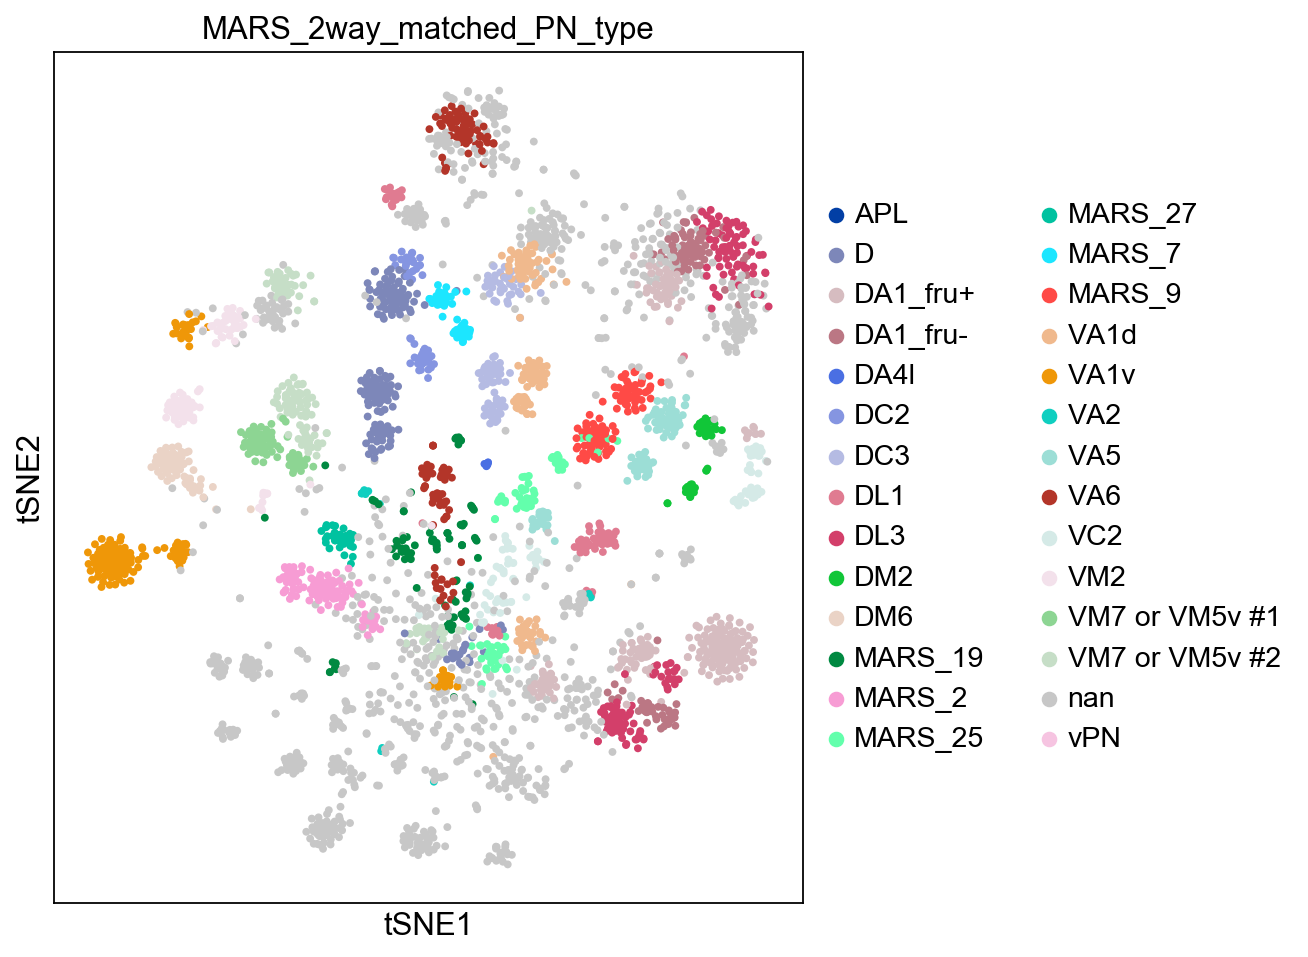

In [23]:
adata_all.obs['MARS_2way_matched_PN_type'] = adata_all.obs['MARS_2way_matched_PN_type'].astype('category')
type_order = adata_all.obs['MARS_2way_matched_PN_type'].cat.categories
adata_all.uns['MARS_2way_matched_PN_type_colors'] = [color_dict[type] for type in type_order]
sc.pl.tsne(adata_all,color='MARS_2way_matched_PN_type', size=(50,50),save='_automatic_matched.pdf')

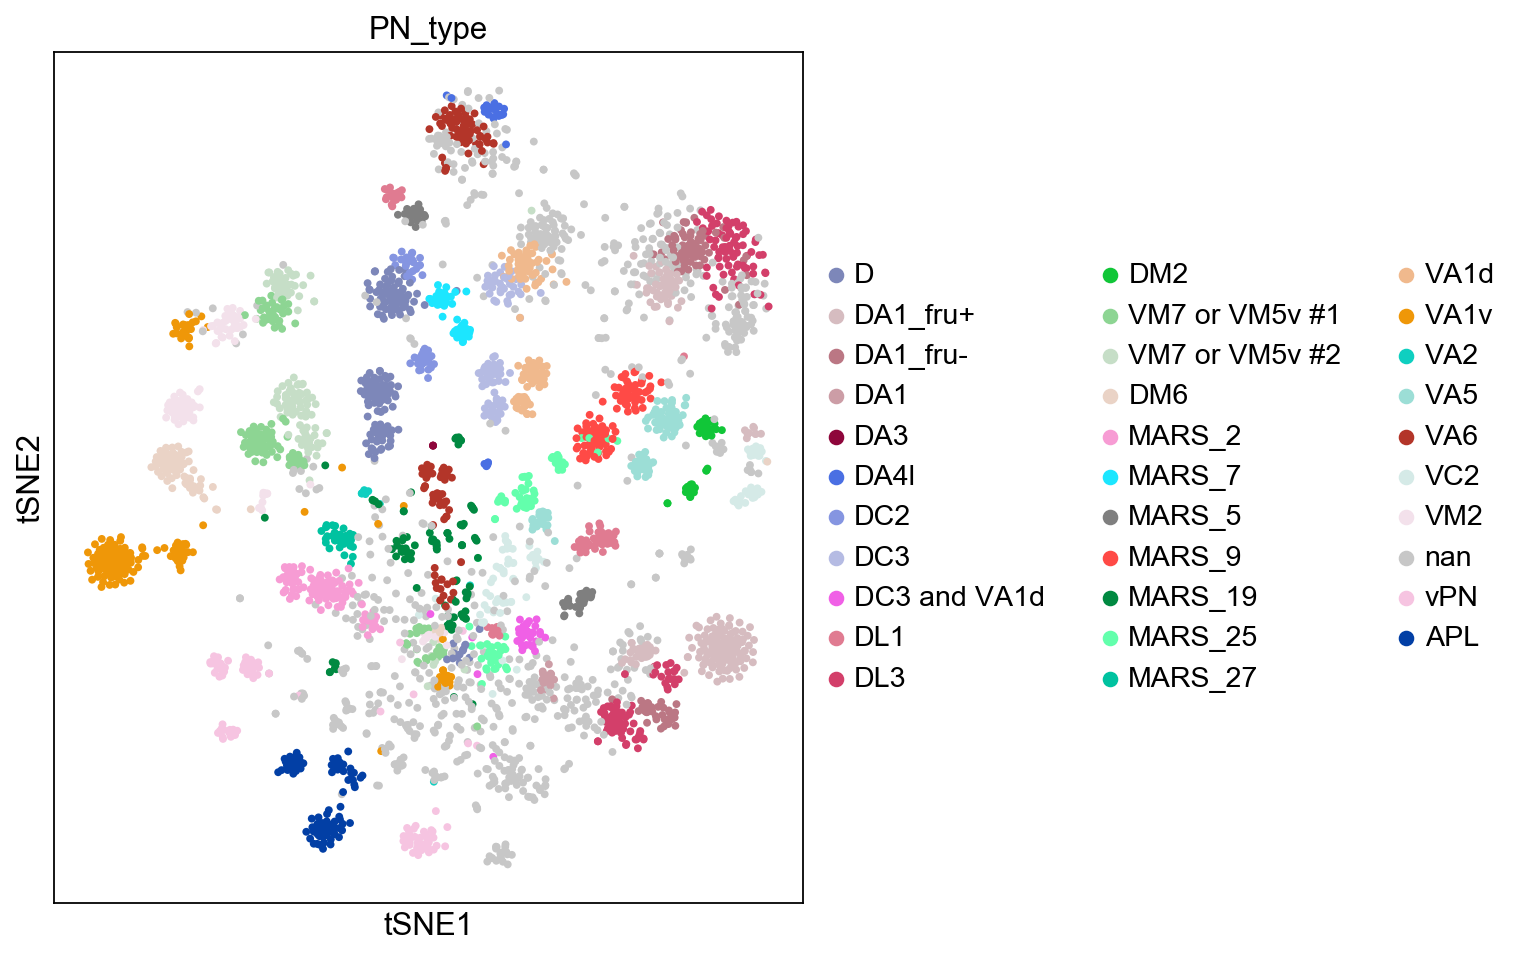

In [25]:
type_order = adata_all.obs['PN_type'].cat.categories
adata_all.uns['PN_type_colors'] = [color_dict[type] for type in type_order]
sc.pl.tsne(adata_all,color='PN_type', size=(50,50), save='_all_decoded.pdf')

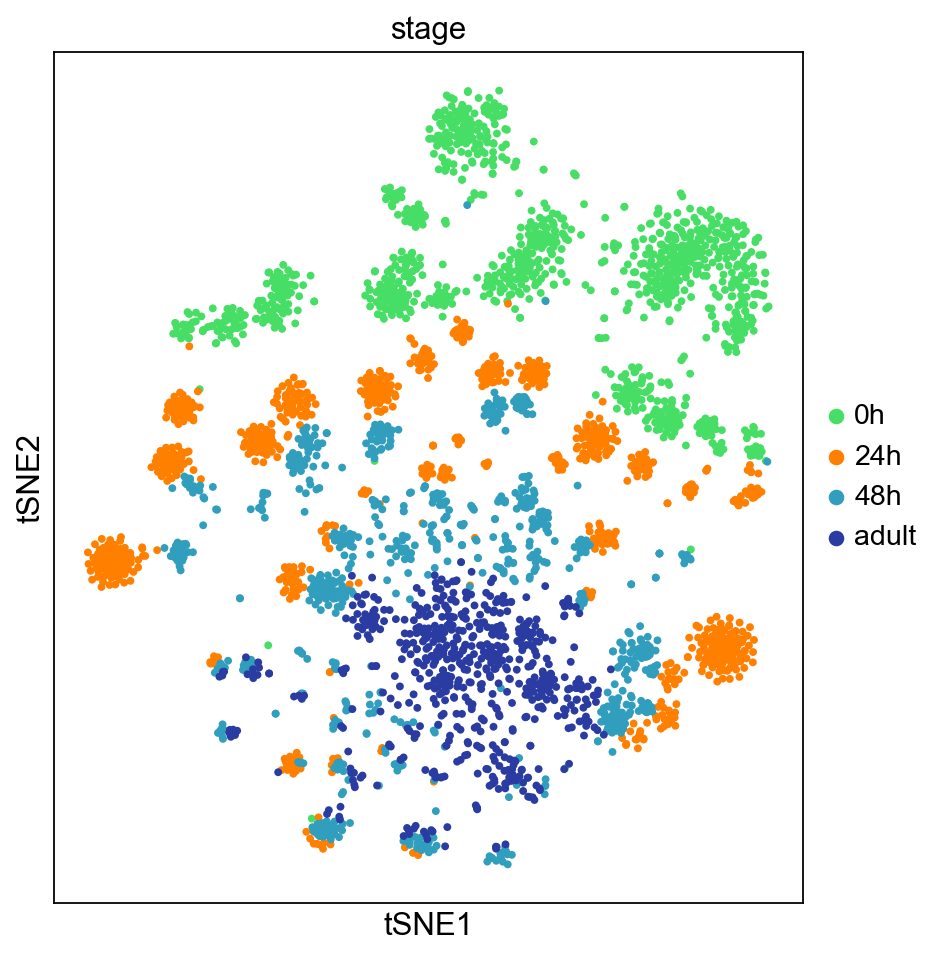

In [11]:
sc.pl.tsne(adata_all,color='stage', size=(50,50),save='_stage.pdf')

In [52]:
all_cate_ori = adata_all.obs.matched_type_with_stage.cat.categories

In [65]:
new_order = ['VA6: 0h','VA6: 24h','VA6: 48h','VA6: adult',
             'VA1v: 0h','VA1v: 24h', 'VA1v: 48h', 'VA1v: adult',
             'DL1: 0h','DL1: 24h','DL1: 48h', 'DL1: adult',
             'VA1d: 0h','VA1d: 24h','VA1d: 48h','DC3 and VA1d: adult','DC3: 0h','DC3: 24h','DC3: 48h',
             'D: 0h','D: 24h', 'D: 48h', 'D: adult',
             'VM7 or VM5v #1: 0h','VM7 or VM5v #1: 24h', 'VM7 or VM5v #1: 48h','VM7 or VM5v #1: adult',
             'VM7 or VM5v #2: 0h','VM7 or VM5v #2: 24h', 'VM7 or VM5v #2: 48h','VM7 or VM5v #2: adult',
             'VM2: 0h','VM2: 24h','VM2: 48h','VM2: adult',
             'DA1_fru+: 0h','DA1_fru+: 24h','DA1_fru+: 48h','DA1_fru-: 0h','DA1_fru-: 24h', 'DA1_fru-: 48h','DA1: adult',
             'VC2: 0h','VC2: 24h', 'VC2: 48h', 'VC2: adult',
             'DL3: 0h','DL3: 24h','DL3: 48h','VA5: 0h','VA5: 24h', 'VA5: 48h',
             'DM6: 24h', 'DM6: 48h','DM6: adult',
             'DA4l: 0h','DA4l: 24h',
             'APL: 24h', 'APL: 48h', 'APL: adult','vPN: 24h', 'vPN: 48h', 'vPN: adult'
             ]

In [66]:
set_1 = set(adata_all.obs.matched_type_with_stage.cat.categories)
set_2 = set(new_order)
adata_all.obs.matched_type_with_stage = adata_all.obs.matched_type_with_stage.cat.remove_categories(list(set_1.difference(set_2)))
adata_all.obs.matched_type_with_stage = adata_all.obs.matched_type_with_stage.cat.add_categories(list(set_2.difference(set_1)))

In [67]:
adata_all.obs['matched_type_with_stage'] = adata_all.obs['matched_type_with_stage'].cat.reorder_categories(new_order)

In [70]:
more_genes_dict = {'lineage':['acj6','vvl'],'VA6':['CG10433','NLaz'],
                   'VA1v':[ 'kn','danr'],
                   'DL1':['CR45223','CG44153'],'DC3 and VA1d':['br','C15','Pde11','run','CG31676'],
                   'D': ['kn','C15'],'VM7 or VM5v':['kn','CG3940','CG9650'],
                   'VM2':['kn','trol','CG1688'],'DA1':['br','tsh','Eip93F'],
                   'VC2':['CG43689', 'vvl'],'DL3':['tsh','beat-IIa','TkR86C','CG31676'],
                   'VA5':['CG15478', 'CG42458'],'DM6':['kn','caup','CBP'],'DA4l':['lov','RunxB'],
                   'APL': ['Wnt4','VGlut','fd102C'],'vPN': ['Gad1','Lim1','toy']
                   }                

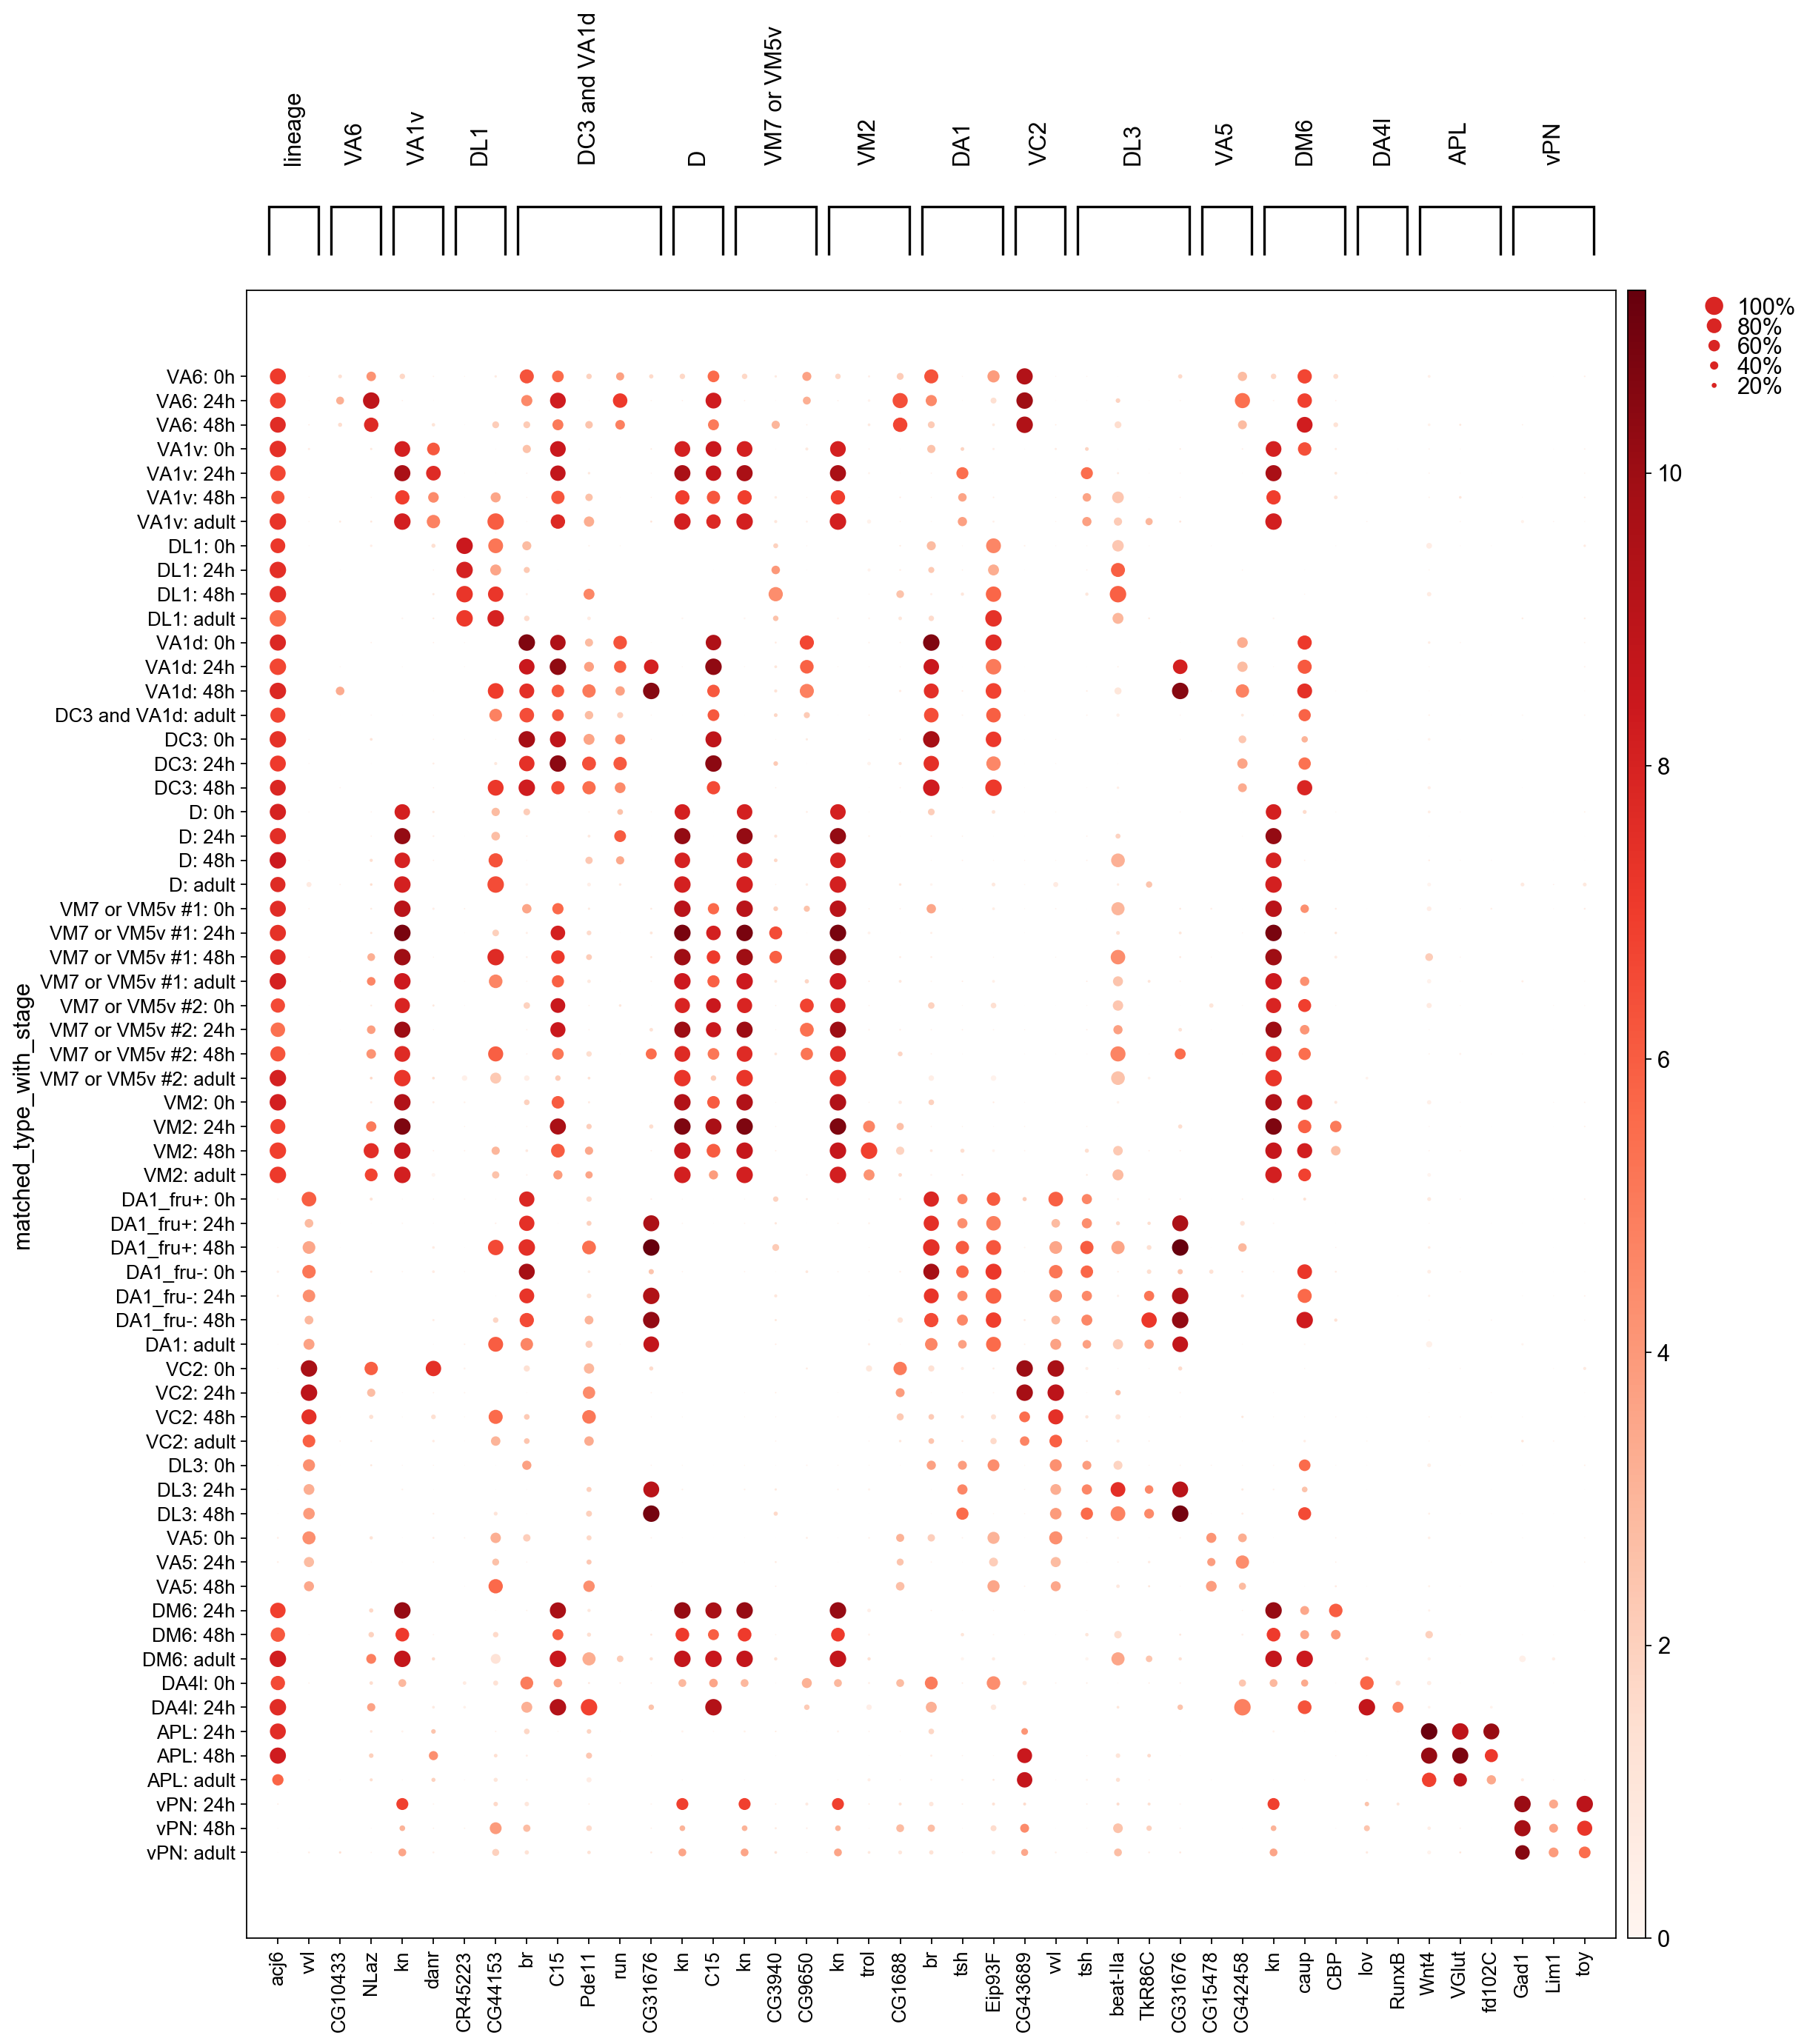

GridSpec(2, 5, height_ratios=[0.5, 10], width_ratios=[15.049999999999999, 0, 0.2, 0.5, 0.25])

In [72]:
sc.set_figure_params(dpi_save=600)
sc.pl.dotplot(adata_all, more_genes_dict, groupby='matched_type_with_stage', save='_decoding_markers.pdf')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


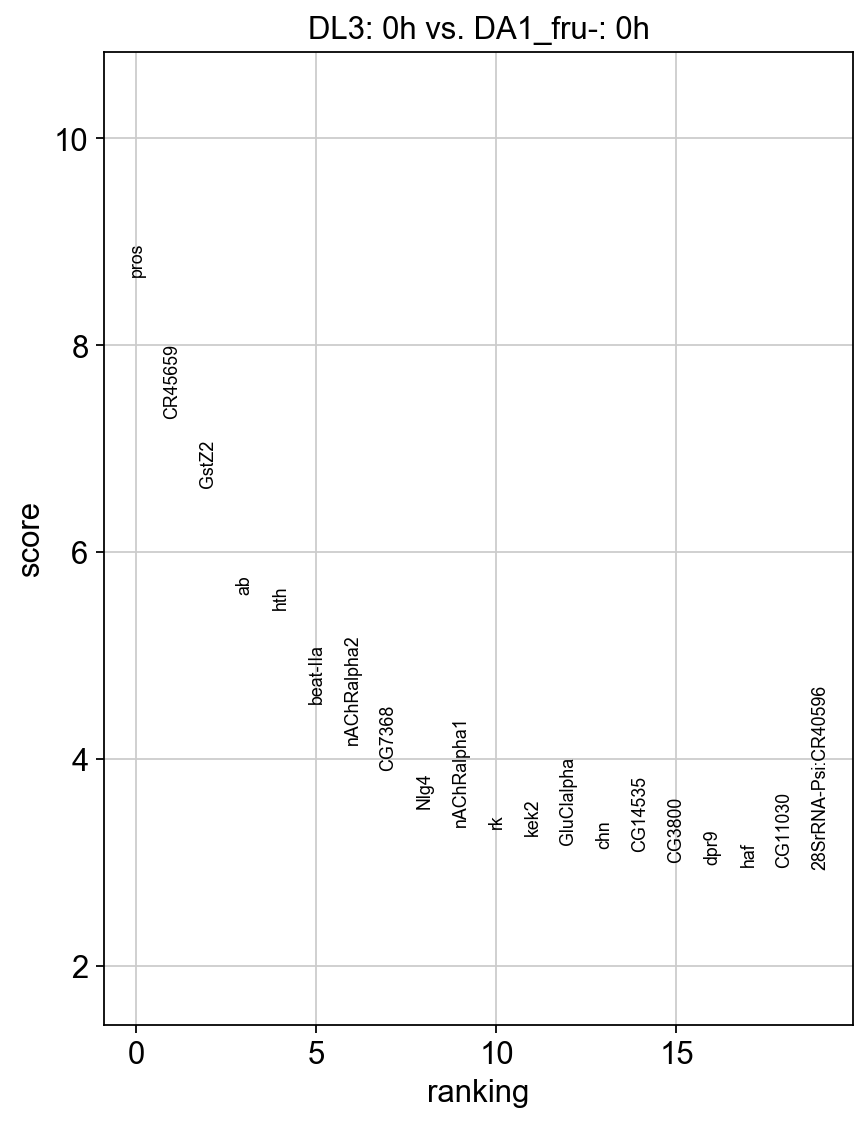

In [235]:
sc.tl.rank_genes_groups(adata_all, 'matched_type_with_stage', groups=['DL3: 0h'], reference='DA1_fru-: 0h', method='wilcoxon')
sc.pl.rank_genes_groups(adata_all, groups=['DL3: 0h'], n_genes=20)

In [ ]:
# new_order = ['DC2: 0h','DC2: 24h','DL3: 0h','DL3: 24h','DL3: 48h',
#              'DA1_fru+: 0h','DA1_fru+: 24h','DA1_fru+: 48h',
#              'DA1_fru-: 0h','DA1_fru-: 24h', 'DA1_fru-: 48h','DA1: adult',
#              'VA1d: 0h','VA1d: 24h','VA1d: 48h','DC3 and VA1d: adult','DC3: 0h','DC3: 24h','DC3: 48h',
#              'DA4l: 24h','DL1: 0h','DL1: 24h','DL1: 48h', 'DL1: adult',
#              'VA6: 0h','VA6: 24h','VA6: 48h','VA6: adult','VA2: 24h','VA5: 0h','VA5: 24h', 'VA5: 48h',
#              'DM2: 0h','DM2: 24h',
#              'VC2: 0h','VC2: 24h', 'VC2: 48h', 'VC2: adult','VA1v: 0h','VA1v: 24h', 'VA1v: 48h', 'VA1v: adult',
#              'D: 0h','D: 24h', 'D: 48h', 'D: adult','VM2: 0h','VM2: 24h','VM2: 48h','VM2: adult',
#              'VM7 or VM5v #1: 0h','VM7 or VM5v #1: 24h', 'VM7 or VM5v #1: 48h','VM7 or VM5v #1: adult',
#              'VM7 or VM5v #2: 0h','VM7 or VM5v #2: 24h', 'VM7 or VM5v #2: 48h', 'VM7 or VM5v #2: adult',
#              'DM6: 24h', 'DM6: 48h','DM6: adult','MARS_2: 24h', 'MARS_2: 48h','MARS_2: adult',
#              'MARS_7: 0h','MARS_7: 24h','MARS_9: 0h','MARS_9: 24h','MARS_19: 24h','MARS_19: 48h', 'MARS_19: adult',
#              'MARS_25: 24h', 'MARS_25: 48h','MARS_25: adult','DA3: 24h',
#              'MARS_27: 24h', 'MARS_27: 48h','APL: 24h', 'APL: 48h', 'APL: adult',
#              'vPN: 24h', 'vPN: 48h', 'vPN: adult']
# adata_select.obs['matched_type_with_stage'] = adata_select.obs['matched_type_with_stage'].cat.reorder_categories(new_order)

In [ ]:
# more_genes_dict = {'lineage':['acj6','vvl'],'DL3':['tsh','CG14401'],'DA1_fru+':['fru','CG31676','CG15537'],
#                    'DA1_fru-':['Scp2','bab2','caup'], 'VA1d':['run','CG31676'],
#                    'DA4l':['zfh2'], 'DL1':['CR45223', 'CG44153', 'CG12594'],'VA6':['CG9650', 'CG10433','NLaz','run','Bx'],
#                    'VA2':['lov','danr'],'VA5':['CG15478', 'CG42458', 'ct'],'DM2':['CG8216', 'CG32052','DIP-eta'],
#                    'VC2':['CR45414', 'CG43689'], 'VA1v':['kn', 'danr', 'tsh'], 'D':['Thor','run'],
#                    'VM2':['trol','DIP-iota'], 'VM7 or VM5v #1':['kn','CG3940', 'CG17278'],
#                    'VM7 or VM5v #2':['kn','CG9650'], 'DM6':['kn','CBP','trol'],'MARS_2':['CG7191'],
#                    'MARS_19': ['CG9650','mAChR-B'], 'APL': ['Wnt4','VGlut','fd102C'],
#                    'vPN': ['Gad1','Lim1','toy']}                

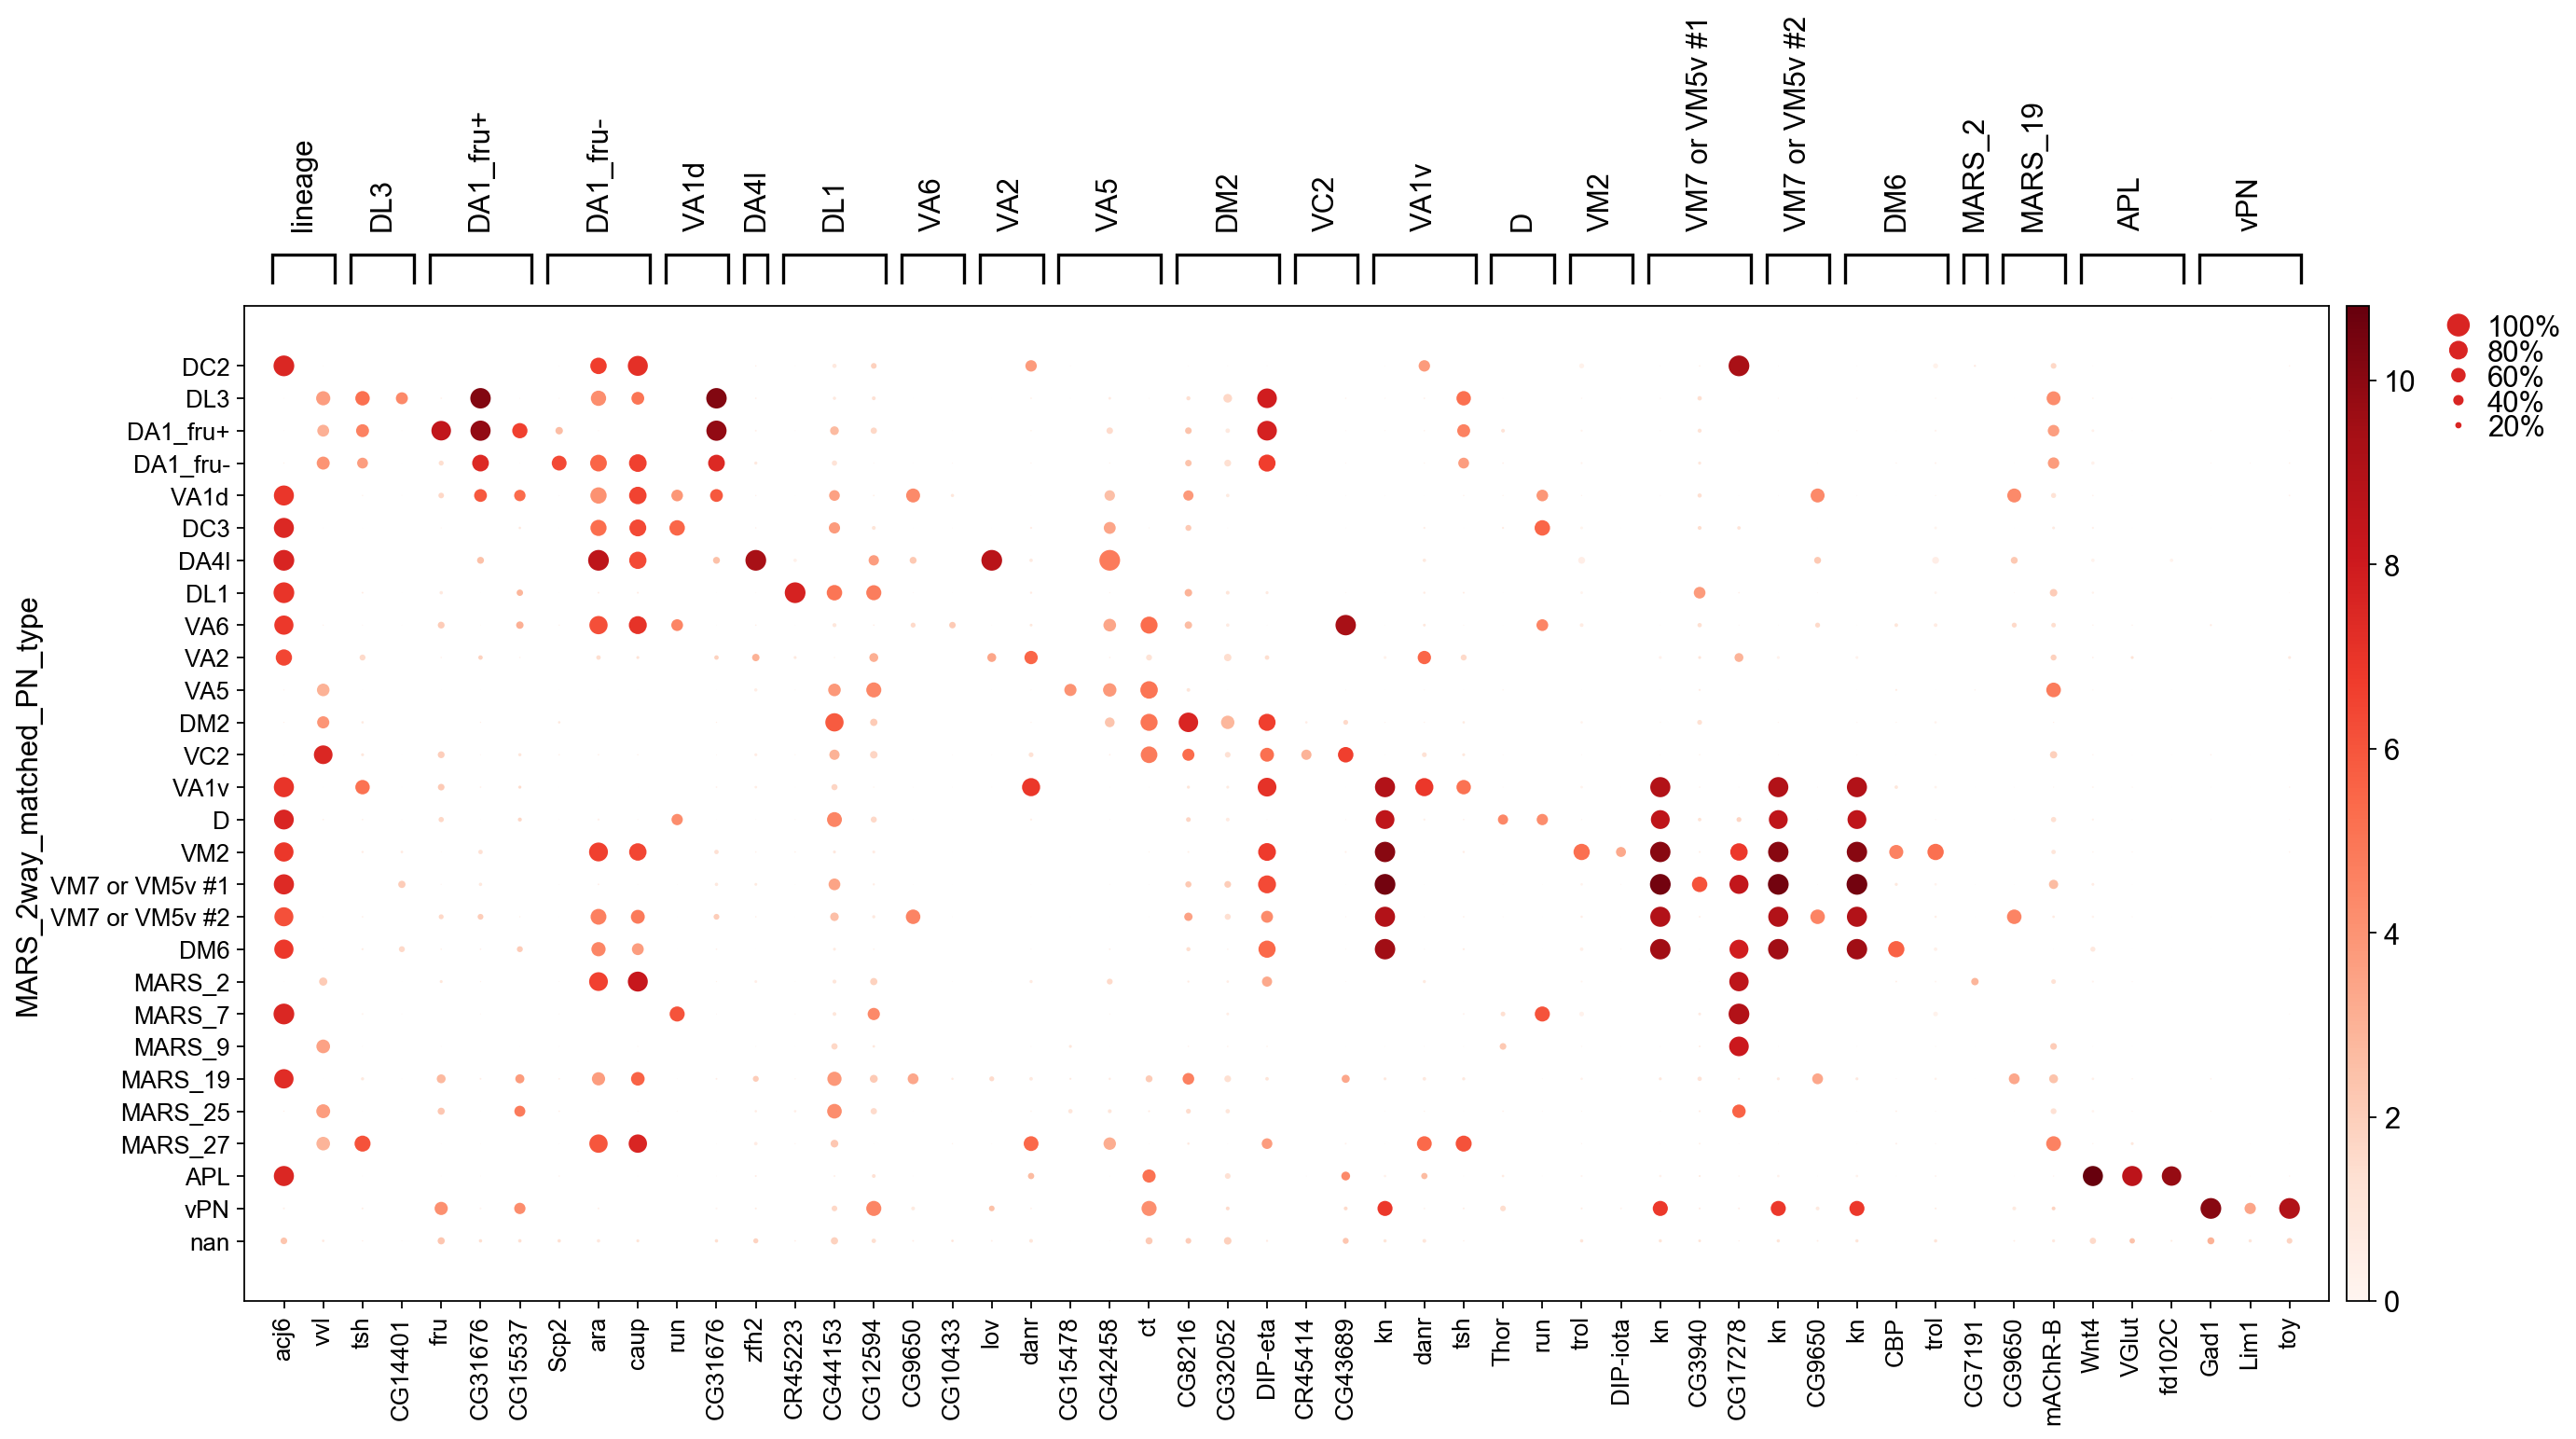

GridSpec(2, 5, height_ratios=[0.5, 10], width_ratios=[18.2, 0, 0.2, 0.5, 0.25])

In [58]:
sc.pl.dotplot(adata_all, more_genes_dict, groupby='MARS_2way_matched_PN_type', save='_decoding_markers.pdf')

In [23]:
adata_all.write_h5ad('../data/adata_all_panPN_annotated_final.h5ad')